# <center> Personal project : Histopathologic cancer detection

### <center> by: Jerome Dauba
    
### made on 29/04/21

## Layout of this notebook :
- Understanding the project and our data of histopathology images
- Important metrics for this project : AUC
- Creating the train set and validation set
- Image preprocessing and Data augmentation
- Creating the classifier (CNN) architecture 
- Creating class for training and evaluating the model
- Displaying results and model understanding
- Next step : Hybrid approach with Deep learning and Machine learning

## Project understanding : 

The data is subset of the PatchCamelyon (PCam) dataset : https://github.com/basveeling/pcamcomes , and is part of the Kaggle challenge : https://www.kaggle.com/c/histopathologic-cancer-detection/data

In this binary classification problem similar to Tribvn work, the goal is to detect the presence of metastases in 96x96 histopathologic images. The difficulty here lies in the fact that we must classify as an **anomaly an image even if it contains only one cancer cell.**

According to : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2910932/, histopathological images are are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin. Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread.

The dataset contains 220k train images and 57k test images. I had to download locally the data because Google Drive and Colab wouldn't allow me to treat that much images.

In [6]:
#General import :
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import random
from numpy import load
from random import shuffle
from math import *
import os

#Visualization :
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-learn utils, metrics :
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Sklearn classification :
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Sklearn clustering :
from sklearn.cluster import KMeans

#Dimension reduction :
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Working with images :
import cv2
from PIL import Image

#Model interpretability
#!pip install captum
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

#Pytorch specific :
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Notebook specific :
from tqdm.notebook import tqdm
from IPython.display import clear_output
# clear_output()

# Data analyzing

**Importing data :**

In [7]:
## Path for colab files :
# path_to_train = '/gdrive/MyDrive/Kaggle_Competitions/histopathologic-cancer-detection/Data2/train/'
# path_to_test = '/gdrive/MyDrive/Kaggle_Competitions/histopathologic-cancer-detection/Data2/test/'
# path_df = '/gdrive/MyDrive/Kaggle_Competitions/histopathologic-cancer-detection/train_labels.csv'


# ## Path to local files :
# path_root = 'C:/Users/Jérôme/Desktop/Cancer_detection/histopathologic-cancer-detection'
# path_df = 'C:/Users/Jérôme/Desktop/Cancer_detection/histopathologic-cancer-detection/train_labels.csv'
# path_to_train = 'C:/Users/Jérôme/Desktop/Cancer_detection/histopathologic-cancer-detection/train/'
# path_to_test = 'C:/Users/Jérôme/Desktop/Cancer_detection/histopathologic-cancer-detection/test/'
# path_submission = 'C:/Users/Jérôme/Desktop/Cancer_detection/histopathologic-cancer-detection/sample_submission.csv'

## Path to local files :
path_root = 'C:/Users/jerom/Downloads/histopathologic-cancer-detection'
path_df = 'C:/Users/jerom/Downloads/histopathologic-cancer-detection/train_labels.csv'
path_to_train = 'C:/Users/jerom/Downloads/histopathologic-cancer-detection/train/'
path_to_test = 'C:/Users/jerom/Downloads/histopathologic-cancer-detection/test/'
path_submission = 'C:/Users/jerom/Downloads/histopathologic-cancer-detection/sample_submission.csv'


df_submission = pd.read_csv(path_submission)
df = pd.read_csv(path_df)
df_class0 = df.loc[df['label']==0]
df_class1 = df.loc[df['label']==1]
id_label_map = {k:v for k,v in zip(df.id.values, df.label.values)}
dic_classes2 = {0:'No Cancer', 1:'Cancer'}

Class 0 - Contains NO tumor tissue


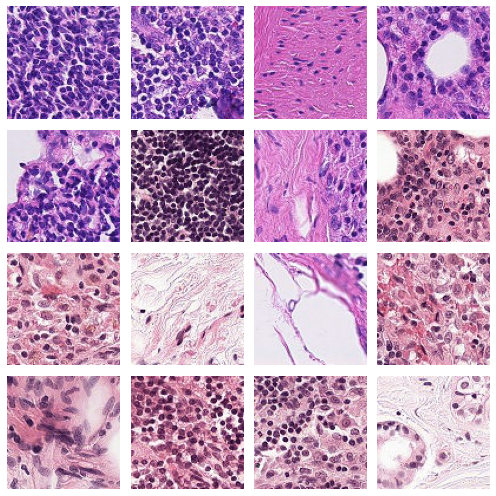


 Class 1 - Contains at least ONE tumor tissue


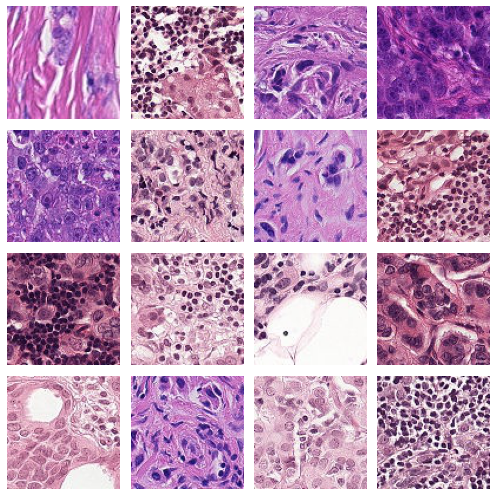

In [8]:
"""**Visualization of some random images :**"""

## Visualizing class 0 :
# Images with NO Tumor tissue in the center region (32x32 pixels)
print("Class 0 - Contains NO tumor tissue")
plt.figure(figsize=(7,7))
for i in range(16):
    image = Image.open(os.path.join(path_to_train, df_class0['id'].sample().item()+'.tif'))
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image)
plt.show()

## Visualizing class 0 :
# Images with at least ONE pixel of Tumor tissue in the center region (32x32 pixels)
print("\n","Class 1 - Contains at least ONE tumor tissue")
plt.figure(figsize=(7,7))
for i in range(16):
    image = Image.open(os.path.join(path_to_train, df_class1['id'].sample().item()+'.tif'))
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image)
plt.show()

**Some details about a random image :**

In [9]:
image = Image.open(os.path.join(path_to_train, df_class1['id'].sample().item()+'.tif'))

print("Image format:",image.format)
print("Image mode:",image.mode)
print('Image size:',image.size)

Image format: TIFF
Image mode: RGB
Image size: (96, 96)


**Labels main statistics :**

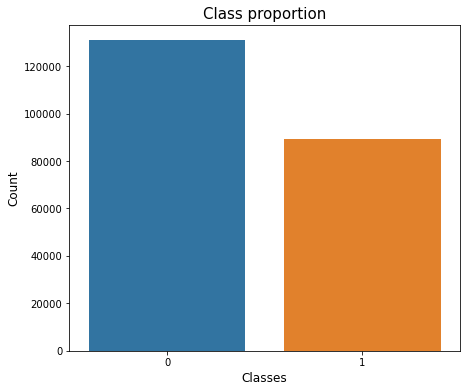

In [10]:
plt.figure(figsize=(7,6))
sns.countplot(x=list(id_label_map.values()))
plt.title("Class proportion", size=15)
plt.xlabel("Classes", size=12)
plt.ylabel("Count", size=12)
plt.show()

The fact that there is 30% less class 1 (anomalies) than class 0 is still reasonable and should not biais the training.

We still can do some data augmentation on our images, such as modifying their aspect (flipping ,saturation, blur, rotation etc...) or we may even think about creating some fakes with a StyleGAN !

## Metrics used :

After having visualized our data, and before tackling the preprocessing techniques, let's quickly recall the essential metrics for this project.

In the case of classification, the most commonly used metric is **AUC** (Area Under the Curve).

The AUC score of a classifier is actually equivalent to the probability that the classifier ranks a randomly chosen positive instance higher than a randomly chosen instance. This is critical in our situation, as we want to make sure that abnormal events (tumor detected in the biopsy) are highlighted with a higher anomaly score than normal events (no tumor tissue).

In the following we will also focus on classic metrics in classification:
- TP: the number of True Positive
- TN: the number of True Negative
- FP: the number of False Positive
- FN: the number of False Negative

In this particular case, we want the lowest number of False Negative (ie: we want to ensure the detection of every abnormal tissue).

## Loading the dataset :

Because Google Drive and Colab couldn't work with 300k images, I downloaded all the rtain and test images in a local folder.

The following class loads the dataset :

In [11]:
class Cancer_detection_Dataset(Dataset):
    """Histopathologic-cancer-detection Dataset."""
    def __init__(self, root_dir, train_file, transform):
        self.root_dir = root_dir
        self.train_file_path = train_file
        self.df_train = pd.read_csv(self.train_file_path)
        self.transform = transform
        self.classes = list(self.df_train['label'].unique())

    def __getitem__(self, idx):
        """Return (image, target) after resize and preprocessing."""
        img = os.path.join(self.root_dir, self.df_train.iloc[idx, 0]+'.tif')
        
        X = Image.open(img)
        y = self.class_to_index(self.df_train.iloc[idx, 1])
        X = np.array(X)
        X = torch.tensor(X)
        X = X.float()
        X = X.permute(2, 0, 1)

        if self.transform:
            X = self.transform(X)
            #print(X.shape) #: 96x96x3
        
        y = torch.tensor([y])
        return X, y
    
    def class_to_index(self, class_name):
        """Returns the index of a given class."""
        return self.classes.index(class_name)
    
    def index_to_class(self, class_index):
        """Returns the class of a given index."""
        return self.classes[class_index]
    
    def class_to_label(self, class_name):
        """Returns the label of a given class"""
        return self.dic_classes[class_name]
    
    def get_class_count(self):
        """Return a list of label occurences"""
        cls_count = dict(self.df_train.label.value_counts())
        return cls_count
    
    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.df_train)

## Transforming input images : Data Augmention

To make a more robust model, I decided to add some Data augmentation : at each epoch (step) of training, the model will see different images thus making it more robust to new images.

Transformations that are done for Data augmentation :
- Resizing (224x224) for Densenet or VGG16
- Random Horizontal or Vertiacl flipping
- Appliying random color modifications (brightness, contrast, saturation) (I had to deactivate this : a lot of images turned black, and I can't understand why for the moment)
- Normalizing all images : The normalization values have been found by extracting the mean and std of all the train image

In [12]:
transform_train = torch.nn.Sequential(
    transforms.CenterCrop(90),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomApply(torch.nn.ModuleList([
        #transforms.ColorJitter(brightness=0.3, contrast=0.0, saturation=0.3, hue=0.1)]), p=0.1),
    transforms.Normalize((179.13/255, 139.29/255, 177.59/255), (46.11/255, 51.17/255, 41.27/255)))

transform_test = torch.nn.Sequential(
    transforms.CenterCrop(90),
    transforms.Resize((224,224)),
    transforms.Normalize((179.13/255, 139.29/255, 177.59/255), (46.11/255, 51.17/255, 41.27/255)))

dataset_train = Cancer_detection_Dataset(root_dir=path_to_train, train_file=path_df, transform=transform_train)
dataset_test = Cancer_detection_Dataset(root_dir=path_to_test, train_file=path_submission, transform=transform_test)

## Class for training and evaluating the model

In this class, we first split our training data into a training set and a validation set (10% of the training set).

Then we can **train** our model, and also **evaluate** it by displaying random images and the model prediction.

Furthermore, I wrote a function in thsi class that enables us to **understand  what the model have learned and display the abnormal areas** (with the library Captum). Indeed, Captum can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

In [13]:
class Train_Eval_Model():
    """Train and / or evaluate a choosen model."""
    def __init__(self, net, dataset_train, dataset_test, batch_size):
        self.dataset_train = dataset_train
        self.dataset_test = dataset_test
        
        self.batch_size = batch_size
        self.validation_split = 0.1
        self.shuffle_dataset = True
        self.random_seed= 42
        
        # Average Mean and Std for all images in the training dataset, for all 3 layers
        self.mean1 = 179.13/255
        self.mean2 = 139.29/255
        self.mean3 = 177.59/255
        self.std1 = 46.11/255
        self.std2 = 51.17/255
        self.std3 = 41.27/255
        
        # Creating data indices for training and validation splits:
        dataset_size = len(self.dataset_train)
        indices = list(range(dataset_size))
        split = int(np.floor(self.validation_split * dataset_size))

        if self.shuffle_dataset :
            np.random.seed(self.random_seed)
            np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        # Creating data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        self.train_loader = torch.utils.data.DataLoader(self.dataset_train, self.batch_size, 
                                                   sampler=train_sampler)
        self.validation_loader = torch.utils.data.DataLoader(self.dataset_train, self.batch_size,
                                                        sampler=valid_sampler)
        self.test_loader = torch.utils.data.DataLoader(self.dataset_test, self.batch_size)
        
        #Loading the model with cuda or cpu
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = net.to(self.device)
        print("GPU :",torch.cuda.get_device_name(0), "activated")
        torch.cuda.empty_cache()
        print("Init OK")
        
   
    def denormalize(self,tensor):
        """Denormalize tensor to display true image"""
        tensor[0,:,:] = tensor[0,:,:]*self.std1 + self.mean1
        tensor[1,:,:] = tensor[1,:,:]*self.std2 + self.mean2
        tensor[2,:,:] = tensor[2,:,:]*self.std3 + self.mean3
        return tensor
    
    def auc_score(self, y_pred,y_true):
        y_pred = y_pred.cpu().detach()
        y_true = y_true.cpu().detach()
        score=roc_auc_score(y_true,y_pred)
        return score
    
    
    def train(self, epochs:int, lr:float):
        torch.cuda.empty_cache()
        self.net.to(self.device)
        
        #Criterion and optimizer :
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.net.parameters(), lr=lr)
        
        #Training :
        self.net.train()
        liste_loss = []
        auc_train_mean, auc_val_mean = [], []
        
        for epoch in tqdm(range(epochs)):
            running_loss = 0.0
            i = 0
            for data_train, data_val in tqdm(zip(self.train_loader, self.validation_loader)):
                # For the training set :
                inputs_train, labels_train = data_train
                labels_train = labels_train.to(torch.float32)
                inputs_train, labels_train = inputs_train.to(self.device), labels_train.to(self.device)

                #For the validation set :
                inputs_val, labels_val = data_val
                labels_val = labels_val.to(torch.float32)
                inputs_val, labels_val = inputs_val.to(self.device), labels_val.to(self.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs_train = self.net(inputs_train)
                outputs_train = outputs_train.float()
                outputs_train = outputs_train #Torch.round is ok too
                outputs_train.to(self.device)

                loss = criterion(outputs_train, labels_train)
                loss.to(self.device)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()

                if i % 20 == 19:    # print every 20 batches
                    with torch.no_grad():
                        outputs_val = self.net(inputs_val)
                        outputs_val = outputs_val.float()
                        outputs_val = outputs_val

                    auc_train = self.auc_score(outputs_train,labels_train)
                    auc_val = self.auc_score(outputs_val,labels_val)
                    auc_val_mean.append(auc_val)
                    auc_train_mean.append(auc_train)

                    print('[%d, %5d] loss: %.3f , AUC train: %.2f , AUC val: %.2f' %
                          (epoch + 1, i + 1, running_loss, auc_train, auc_val))
                    liste_loss.append(running_loss)
                    running_loss = 0.0  
                i+=1
        print('Finished Training')
        print("\n", "AUC train mean:", np.mean(auc_train_mean[-int(len(self.train_loader)/20):]))
        print("\n", "AUC val mean:", np.mean(auc_val_mean[-int(len(self.validation_loader)/20):]))
        plt.figure(figsize=(10,7))
        plt.plot(liste_loss, label='Training loss')
        plt.legend()
        plt.title("Training loss")
        plt.show()

        #Plot AUC evolution for Train and Val :
        plt.figure(figsize=(10,7))
        plt.plot(auc_train_mean,label='AUC train')
        plt.plot(auc_val_mean,label='AUC val')
        plt.legend()
        plt.show()
        
        
    def save(self, out_name:str):
        torch.save(self.net.state_dict(), out_name)
        print('Model weights successfully saved !')
        
    def load(self, path_load:str):
        self.net.load_state_dict(torch.load(path_load))
        self.net.to(self.device)
        print("Model loaded successfully")
        
    def show_eval_mosaique(self):
        """ Show a mosaique of 32 images, display
        their true labels and the associated prediction"""
        self.net.eval()
        liste_auc = []
        for i, data in enumerate(self.train_loader):
            with torch.no_grad():
                inputs, labels  = data
                labels = labels.to(torch.float32)
                inputs = inputs.to(self.device)

                outputs = self.net(inputs)
                outputs = torch.round(outputs.float())
                liste_auc.append(self.auc_score(outputs.cpu(),labels))
            break

        #Displaying the images and their true & predicted labels :
        plt.figure(figsize=(25,50))
        for j, image in enumerate(inputs):
            image = image.cpu()
            image = self.denormalize(image)
            image = np.transpose(image, (1,2,0))
            image = np.array(image, dtype=np.uint8)
            plt.subplot(16,4,j+1)
            plt.imshow(image)
            plt.title(f'{dic_classes2[int(labels[j].item())]}, prediction {labels[j].item()==outputs[j].item()}',
                     size=13)
            plt.axis('off')
        print("AUC mean on this batch :", np.mean(liste_auc))
        plt.show()
        
        print('\n', "Confusion Matrix:")
        conf_matrix = confusion_matrix(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
        disp.plot()

    
    def explain_image(self,image):
        """Understanding how our model works with Captum :
        Captum can estimate which areas of the image are critical 
        for the classifier's decision by occluding them and 
        quantifying how the decision changes.

        We run a sliding window of size 5x5 
        (defined via sliding_window_shapes) with a stride of 4 
        along both image dimensions (a defined via strides)."""
    
        occlusion = Occlusion(self.net)

        attributions_occ = occlusion.attribute(image.unsqueeze(0),
                                           strides = (3, 4, 4),
                                           target=None,
                                           sliding_window_shapes=(3,5, 5),
                                           baselines=0)

        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.uint8(np.transpose(self.denormalize(image.squeeze().detach().cpu()), (1,2,0))),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True,
                                          outlier_perc=4,
                                         cmap='Reds')
        
    def show_eval_explained(self, explain:bool):
        """ Display a random image in the train set 
        and its heatmap with the occlusion method"""
        self.net.eval()

        rand = random.randint(0,len(self.train_loader))
        inputs, labels = self.train_loader.dataset[rand][0], self.train_loader.dataset[rand][1]
        labels = labels.to(torch.float32)
        inputs_explain = inputs.clone().to(self.device)
        inputs = inputs.unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.net(inputs)
            print("Output probability: %.3f" % (outputs.item()))
            outputs = torch.round(outputs.float())

        #Plotting the results :
        image = inputs.squeeze().detach().cpu()
        image = self.denormalize(image)

        image = np.transpose(image, (1,2,0))
        image = np.array(image, dtype=np.uint8)

        plt.imshow(image)
        plt.title(f'{dic_classes2[int(labels.item())]}, prediction {labels.item()==outputs.item()}', size=15)
        plt.axis('Off')
        plt.show()

        if explain :
            print("Interpreting prediction results. This could take up to 1 long minute...")
            print("Highlighting areas that led to that prediction...")
            self.explain_image(inputs_explain)
            
    def submit_test(self, filename:str):
        self.net.eval()
        liste_outputs = []
        print('Evaluating test set...')
        for i, data in tqdm(enumerate(self.test_loader)):
            with torch.no_grad():
                inputs, labels  = data
                labels = labels.to(torch.float32)
                inputs = inputs.to(self.device)
                outputs = self.net(inputs)
                outputs = torch.round(outputs.float())
                liste_outputs.append(outputs)
        liste_outputs2 = []
        for i in tqdm(range(len(liste_outputs))):
            for j in liste_outputs[i]:
                liste_outputs2.append(int(j.item()))
        df_submission['label'] = liste_outputs2
        df_submission.to_csv(filename, index=False)
        print("Submission successfully downloaded !")

**Defining the Neural Network :**

In [14]:
""" Naive CNN : gives a mean AUC of 0.85 ! """
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(64, 16, 3)
#         self.fc1 = nn.Linear(7744, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 1)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
# #         print("Après conv", x.shape)
#         x = x.view(batch_size, -1)
# #         print("Après view", x.shape)
#         x = F.relu(self.fc1(x))
# #         print("Après fc1", x.shape)
#         x = F.relu(self.fc2(x))
# #         print("Après fc2", x.shape)
#         x = self.fc3(x)
#         return torch.sigmoid(x)

""" CNN with a pretrained Densenet 169 & dense layers to classify """
class Net1(nn.Module):
    def __init__(self, pretrained):
        super(Net1, self).__init__()
        self.model = models.densenet169(pretrained=pretrained)
        self.linear1 = nn.Linear(1000+2, 512)
        self.linear2 = nn.Linear(512, 16)
        self.dropout = nn.Dropout(0.2)
        self.elu = nn.ELU()
        self.out = nn.Linear(16, 1)
    
    def forward(self, x):
        out = self.model(x)
        batch = out.shape[0]
        max_pool, _ = torch.max(out, 1, keepdim=True)
        avg_pool = torch.mean(out, 1, keepdim=True)

        out = out.view(batch, -1)
        conc = torch.cat((out, max_pool, avg_pool), 1)

        conc = self.linear1(conc)
        conc = self.elu(conc)
        conc = self.dropout(conc)
        conc = self.linear2(conc)
        conc = self.elu(conc)

        res = self.out(conc)
        return torch.sigmoid(res)

## Let's train :

In [16]:
model = Train_Eval_Model(Net1(pretrained=True), dataset_train, dataset_test, batch_size=32)

[1,    20] loss: 10.082 , AUC train: 0.94 , AUC val: 0.93
[1,    40] loss: 6.270 , AUC train: 0.83 , AUC val: 0.98
[1,    60] loss: 6.360 , AUC train: 1.00 , AUC val: 0.95
[1,    80] loss: 6.724 , AUC train: 0.97 , AUC val: 1.00
[1,   100] loss: 5.815 , AUC train: 0.92 , AUC val: 0.95
[1,   120] loss: 6.113 , AUC train: 0.91 , AUC val: 0.97
[1,   140] loss: 5.528 , AUC train: 0.99 , AUC val: 0.87
[1,   160] loss: 5.662 , AUC train: 0.95 , AUC val: 0.99
[1,   180] loss: 5.689 , AUC train: 0.94 , AUC val: 1.00
[1,   200] loss: 4.889 , AUC train: 1.00 , AUC val: 0.99
[1,   220] loss: 4.483 , AUC train: 0.96 , AUC val: 1.00
[1,   240] loss: 4.089 , AUC train: 0.99 , AUC val: 1.00
[1,   260] loss: 6.010 , AUC train: 0.96 , AUC val: 0.98
[1,   280] loss: 5.602 , AUC train: 0.94 , AUC val: 0.97
[1,   300] loss: 4.524 , AUC train: 1.00 , AUC val: 0.97
[1,   320] loss: 4.744 , AUC train: 0.98 , AUC val: 0.92
[1,   340] loss: 4.672 , AUC train: 1.00 , AUC val: 0.96
[1,   360] loss: 5.433 , AUC t

[2,    20] loss: 4.242 , AUC train: 0.96 , AUC val: 0.99
[2,    40] loss: 4.466 , AUC train: 0.97 , AUC val: 0.96
[2,    60] loss: 4.678 , AUC train: 1.00 , AUC val: 0.98
[2,    80] loss: 4.308 , AUC train: 0.99 , AUC val: 0.97
[2,   100] loss: 3.293 , AUC train: 0.99 , AUC val: 0.99
[2,   120] loss: 3.650 , AUC train: 0.98 , AUC val: 0.99
[2,   140] loss: 3.153 , AUC train: 1.00 , AUC val: 0.98
[2,   160] loss: 4.044 , AUC train: 0.98 , AUC val: 1.00
[2,   180] loss: 3.710 , AUC train: 1.00 , AUC val: 0.97
[2,   200] loss: 4.033 , AUC train: 0.98 , AUC val: 0.99
[2,   220] loss: 4.137 , AUC train: 1.00 , AUC val: 0.99
[2,   240] loss: 3.681 , AUC train: 0.97 , AUC val: 0.96
[2,   260] loss: 3.658 , AUC train: 0.95 , AUC val: 0.96
[2,   280] loss: 4.287 , AUC train: 1.00 , AUC val: 0.99
[2,   300] loss: 3.788 , AUC train: 1.00 , AUC val: 0.95
[2,   320] loss: 4.195 , AUC train: 0.99 , AUC val: 0.99
[2,   340] loss: 3.771 , AUC train: 0.97 , AUC val: 1.00
[2,   360] loss: 3.467 , AUC tr

[3,    20] loss: 3.663 , AUC train: 0.97 , AUC val: 0.98
[3,    40] loss: 4.574 , AUC train: 1.00 , AUC val: 1.00
[3,    60] loss: 3.786 , AUC train: 0.97 , AUC val: 0.97
[3,    80] loss: 3.070 , AUC train: 0.97 , AUC val: 0.99
[3,   100] loss: 3.188 , AUC train: 0.98 , AUC val: 1.00
[3,   120] loss: 4.088 , AUC train: 0.99 , AUC val: 0.98
[3,   140] loss: 3.801 , AUC train: 0.98 , AUC val: 0.96
[3,   160] loss: 3.591 , AUC train: 0.99 , AUC val: 0.90
[3,   180] loss: 4.411 , AUC train: 0.95 , AUC val: 1.00
[3,   200] loss: 2.628 , AUC train: 1.00 , AUC val: 0.92
[3,   220] loss: 3.784 , AUC train: 0.98 , AUC val: 0.96
[3,   240] loss: 4.417 , AUC train: 0.96 , AUC val: 1.00
[3,   260] loss: 3.822 , AUC train: 0.93 , AUC val: 0.97
[3,   280] loss: 2.763 , AUC train: 1.00 , AUC val: 0.94
[3,   300] loss: 3.489 , AUC train: 0.99 , AUC val: 1.00
[3,   320] loss: 4.060 , AUC train: 0.96 , AUC val: 0.87
[3,   340] loss: 3.308 , AUC train: 0.94 , AUC val: 1.00
[3,   360] loss: 3.685 , AUC tr

[4,    20] loss: 3.052 , AUC train: 0.99 , AUC val: 1.00
[4,    40] loss: 3.076 , AUC train: 1.00 , AUC val: 0.99
[4,    60] loss: 3.621 , AUC train: 1.00 , AUC val: 1.00
[4,    80] loss: 3.303 , AUC train: 1.00 , AUC val: 0.98
[4,   100] loss: 2.627 , AUC train: 1.00 , AUC val: 0.98
[4,   120] loss: 3.106 , AUC train: 1.00 , AUC val: 0.97
[4,   140] loss: 3.000 , AUC train: 0.98 , AUC val: 0.97
[4,   160] loss: 2.183 , AUC train: 1.00 , AUC val: 1.00
[4,   180] loss: 2.564 , AUC train: 1.00 , AUC val: 1.00
[4,   200] loss: 3.825 , AUC train: 0.88 , AUC val: 0.98
[4,   220] loss: 3.917 , AUC train: 1.00 , AUC val: 1.00
[4,   240] loss: 2.821 , AUC train: 0.99 , AUC val: 1.00
[4,   260] loss: 2.856 , AUC train: 0.94 , AUC val: 0.95
[4,   280] loss: 3.794 , AUC train: 0.99 , AUC val: 1.00
[4,   300] loss: 3.843 , AUC train: 0.99 , AUC val: 0.99
[4,   320] loss: 2.610 , AUC train: 0.99 , AUC val: 1.00
[4,   340] loss: 2.988 , AUC train: 0.98 , AUC val: 1.00
[4,   360] loss: 3.663 , AUC tr

[5,    20] loss: 2.448 , AUC train: 1.00 , AUC val: 0.94
[5,    40] loss: 3.006 , AUC train: 0.99 , AUC val: 0.99
[5,    60] loss: 2.565 , AUC train: 1.00 , AUC val: 1.00
[5,    80] loss: 2.663 , AUC train: 1.00 , AUC val: 1.00
[5,   100] loss: 3.334 , AUC train: 1.00 , AUC val: 0.99
[5,   120] loss: 3.077 , AUC train: 0.98 , AUC val: 0.97
[5,   140] loss: 2.695 , AUC train: 1.00 , AUC val: 1.00
[5,   160] loss: 2.996 , AUC train: 0.98 , AUC val: 0.99
[5,   180] loss: 3.293 , AUC train: 1.00 , AUC val: 1.00
[5,   200] loss: 3.366 , AUC train: 0.96 , AUC val: 0.99
[5,   220] loss: 2.996 , AUC train: 0.96 , AUC val: 1.00
[5,   240] loss: 3.085 , AUC train: 1.00 , AUC val: 1.00
[5,   260] loss: 3.295 , AUC train: 1.00 , AUC val: 1.00
[5,   280] loss: 2.705 , AUC train: 0.98 , AUC val: 1.00
[5,   300] loss: 2.520 , AUC train: 0.99 , AUC val: 0.99
[5,   320] loss: 3.075 , AUC train: 1.00 , AUC val: 1.00
[5,   340] loss: 2.209 , AUC train: 0.97 , AUC val: 1.00
[5,   360] loss: 3.119 , AUC tr

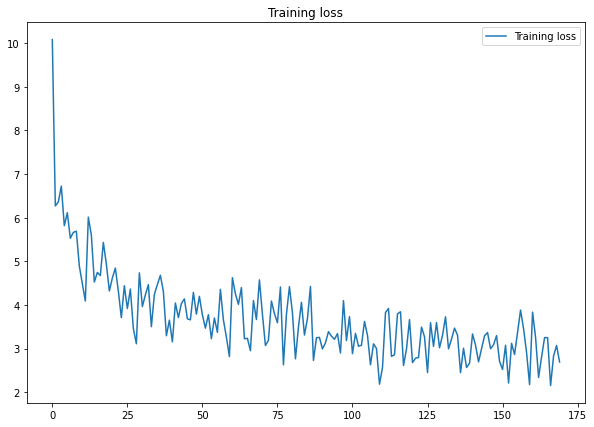

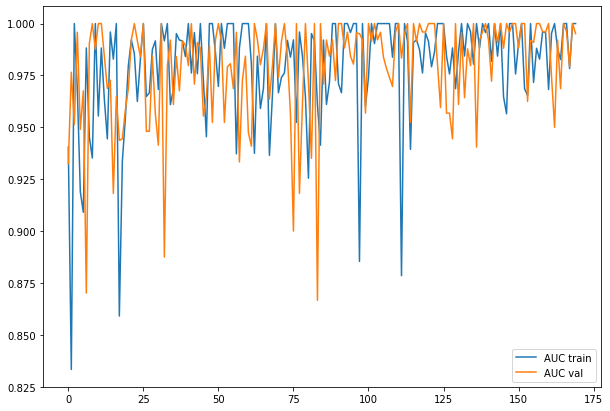

In [25]:
model.train(epochs=5, lr=1e-4)

As we can see, this model have a great performance : the combination of the pretrained DenseNet and then the dense layers for classification enables us to have a final Mean AUC = 0.989 for the validation set.

The mean AUC for training and validation are also roughly the same : there is no overfitting there.

I've tested this model with several others pretrained networks (VGG16, Resnet, etc...) but the DenseNet169 have performed better.

Then, we can save the models weights and display some random images and their predictions in a mosaique :

In [26]:
# model.save(out_name='V11_best.pth')

Model weights successfully saved !


Model loaded successfully
AUC mean on this batch : 0.9736842105263158


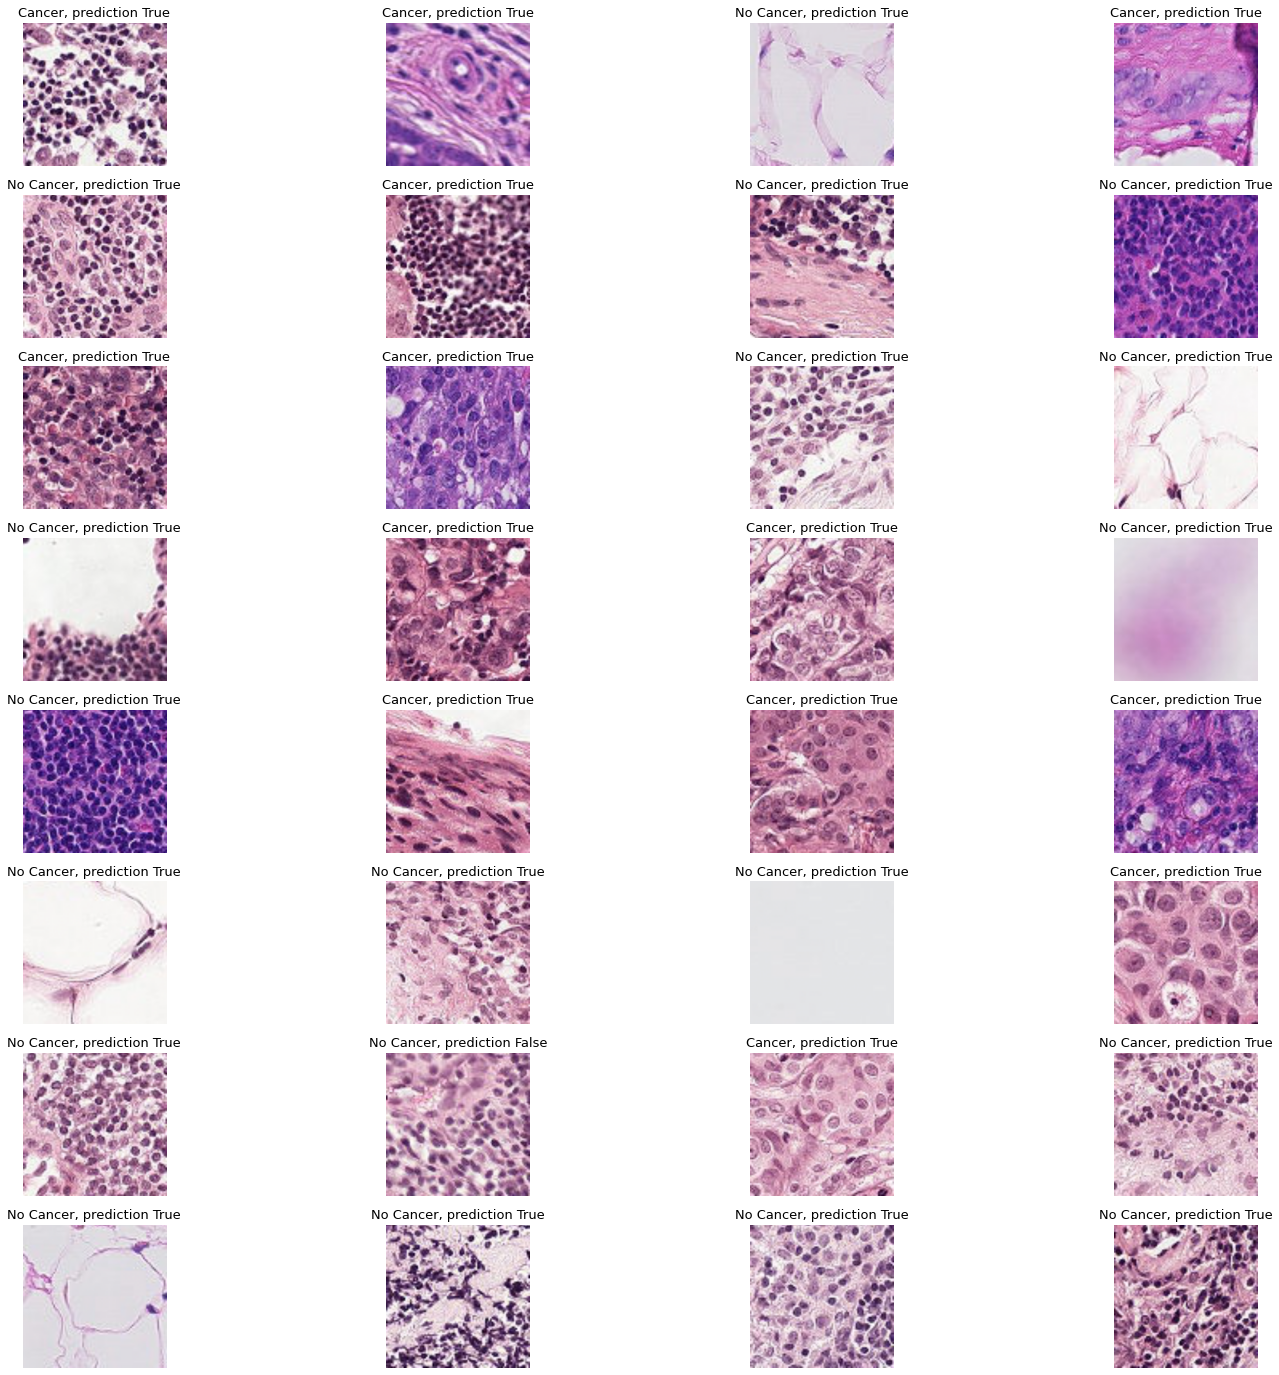


 Confusion Matrix:


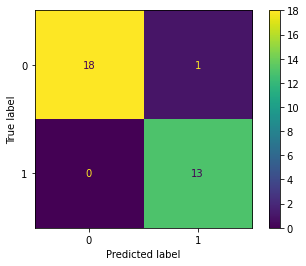

In [38]:
model.load('V11_best.pth')
model.show_eval_mosaique()

## Evaluate and explain the prediction :

In this part, I use the library Captum that estimates which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

In other words, for images containing a metastase, this script will highlight the part of the image that contains the cancer cell and that led to that prediction !

Output probability: 1.000


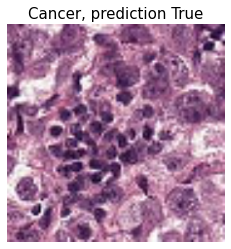

Interpreting prediction results. This could take up to 1 long minute...
Highlighting areas that led to that prediction...


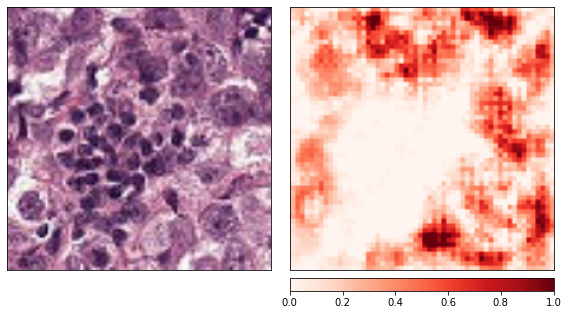

In [55]:
#Example 1 :
model.show_eval_explained(explain=True)

Output probability: 0.993


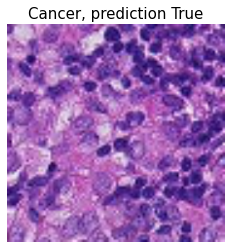

Interpreting prediction results. This could take up to 1 long minute...
Highlighting areas that led to that prediction...


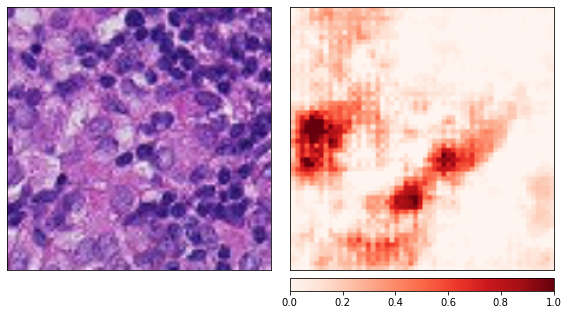

In [61]:
#Example 2 :
model.show_eval_explained(explain=True)

Submitting test csv for Kaggle challenge :

In [ ]:
model.submit_test(filename='submit4.csv')

## Hybrid approach : Deep Learning + Machine Learning

In this approach, I have replaced the dense layers at the end of the previous neural network by some Machine Learning.

Indeed, the DenseNet169 pretrained is used to extract 1002 features for each image.
To avoid the 'Curse of dimensionality', I've decided to reduce the features dimensions with a PCA or LDA. The best method seems to be LDA, which reduces the dimension to (N,1), with N the number of train images.

Then, several Machine learning algorithms have been tested to classify the features, such as SVM, AdaBoost or an HistogramGradientBoosting method.

Those algorithms are trained on the whole training set after hyperparameter tuning with a validation set. Then, we will select randomly a batch of images, extract features, reduce dimension and then make a prediction.

In [13]:
class Train_Eval_Model(Train_Eval_Model):
    # subclassing for continuity
    def __init__(self, net, dataset_train, dataset_test, batch_size):
        super(Train_Eval_Model, self).__init__(net, dataset_train, dataset_test, batch_size)
        self.pca = PCA(n_components=64)
        self.lda = LinearDiscriminantAnalysis(n_components=1)
        self.feature_extractor = models.densenet169(pretrained=True).to(self.device)
        self.train_loader_extract = torch.utils.data.DataLoader(self.dataset_train, self.batch_size)
    
    def forward_feature_extract(self, x):
        out = self.feature_extractor(x)
        batch = out.shape[0]
        max_pool, _ = torch.max(out, 1, keepdim=True)
        avg_pool = torch.mean(out, 1, keepdim=True)
        out = out.view(batch, -1)
        x = torch.cat((out, max_pool, avg_pool), 1)
        return(x)

    
    def extract_features(self, load_saved:bool):
        """"Feature extraction + PCA to reduce dimension"""
        
        if load_saved :
            #Load local npz files (to save time):
            dict_X = load('X_features.npz')
            dict_y = load('y_features.npz')

            X_features = dict_X['arr_0']
            y_features = dict_y['arr_0']
            return(X_features, y_features)
        
        else :
            self.net.eval()
            liste_X_out, liste_y_out = [], []
            for i, data in tqdm(enumerate(self.train_loader_extract)):
                with torch.no_grad():
                    inputs, labels  = data
                    labels = labels.to(torch.float32)
                    inputs = inputs.to(self.device)

                    X = self.forward_feature_extract(inputs)
                    X = X.detach().cpu().numpy()
                    y = labels.detach().cpu().numpy()

                    liste_X_out.append(X)
                    liste_y_out.append(y)

            return(liste_X_out, liste_y_out)
    
    def reduce_dimension(self, X, y, method:str):
        if method == 'PCA':
            self.reduce = self.pca.fit(X)
            X = self.reduce.transform(X)
        elif method == 'LDA':
            self.reduce = self.lda.fit(X, y.ravel())
            X = self.reduce.transform(X)
        return(X,y)
            
    
    def fit(self, X, y, model_ML:str, method_reduce:str):
        
        X, y = self.reduce_dimension(X, y, method=method_reduce)
        print("Extracted features dimensions reduced to :")
        print(X.shape)
        
        if model_ML == 'adaboost':
            self.clf = AdaBoostClassifier(n_estimators=100).fit(X, y.ravel())
        elif model_ML == 'histgboost':
            self.clf = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=2000).fit(X, y.ravel())
        elif model_ML == 'SVC':
            self.clf = SVC(gamma='scale').fit(X, y)
        elif model_ML == 'KNN':
            self.clf = KNeighborsClassifier(n_neighbors=5).fit(X,y.ravel())
        
    
    def predict_hybrid(self, loader_name:str):
        if loader_name == 'train':
            loader = self.train_loader
        elif loader_name == 'val':
            loader = self.validation_loader
        elif loader_name == 'test':
            loader = self.test_loader
        elif loader_name == 'extract':
            loader = self.train_loader_extract
        
        for i, data in enumerate(loader):
                with torch.no_grad():
                    inputs, labels  = data
                    labels = labels.to(torch.float32)
                    inputs = inputs.to(self.device)
                    
                    #Feature extraction :
                    X = self.forward_feature_extract(inputs)
                    X = X.detach().cpu().numpy()
                    y_true = labels.detach().cpu().numpy()
                    
                    #Dimension reduction :
                    X = self.reduce.transform(X)
                    
                    #Machine Learning prediction :
                    #y_predict = self.clf.predict(np.tanh(X))
                    y_predict = self.clf.predict(X)
                print("AUC mean predicted on the batch :",roc_auc_score(y_predict,y_true))
                    
                break

In [14]:
model = Train_Eval_Model(Net1(pretrained=True), dataset_train, dataset_test, batch_size=64)

GPU : NVIDIA GeForce RTX 2070 activated
Init OK


In [16]:
X_features, y_features = model.extract_features(load_saved=True)

In [17]:
model.fit(X_features, y_features, model_ML = 'histgboost', method_reduce='LDA')
# model.fit(X_features, y_features, model_ML = 'histgboost', method_reduce:'PCA')

Extracted features dimensions reduced to :
(220025, 1)


In [18]:
model.predict_hybrid(loader_name='extract')

AUC mean predicted on the batch : 0.7478354978354977


As we can see, replacing the dense layers with Machine learning give a worse result of AUC mean, around 75%.

The next step would to analyse the cause of this :
- Dimension reduction that erase some essentials features ?
- Bad hyperparameters tuning ?

**And for better results, a team work would be obviously needed !**

-------
Thanks for reading !